<a href="https://colab.research.google.com/github/otrilas/IA/blob/main/MLP_Red_Neu_Ejecio_2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/025_mlp_framework/mlp_framework.ipynb)

# El Perceptrón Multicapa - Nuestro propio Framework

En el [post](https://sensioai.com/blog/024_mlp_clasificacion) anterior completamos una implementación del Perceptrón Multicapa capaz de llevar a cabo tareas de `regresión` y `clasificación`. Sin embargo, esta implementación tiene muchas limitaciones. Por ejemplo, sólo sirve para un perceptrón multicapa con una capa oculta con funciones de activación de tipo `relu`, entre otras. Aún así, programar todos los elementos envueltos en un arquitectura en concreto es muy útil para entender qué está pasando dentro de la `red neuronal` en todo momento. En este post vamos a mejorar la implementación para resolver estas limitaciones, haciendo nuestro propio framework inspirado en [Pytorch](https://pytorch.org/).

## Diseño de la API

Nuestro objetivo es el de ser capaces de resolver los problemas que hemos visto hasta ahora con una interfaz similar a la siguiente:

En primer lugar, queremos definir nuestro `MLP` como una secuencia de capas, las cuales pasaremos como una lista a la clase `MLP`. Como puedes ver, de esta manera, podemos usar diferentes funciones de activación simplemente cambiando la clase utilizada. Después, definiremos los objetos `optimizer` y `loss` como clases particulares de manera que podamos, de manera totalmente transparente, utilizar diferentes funciones de pérdida o algoritmos de optimización simplemente cambiando la clase en cuestión. Por último, en el bucle de entrenamiento, querremos ser capaces de calcular la salida del modelo, gradientes y actualizar los pesos de manera automática. Vamos a ver cómo conseguirlo en las siguientes secciones.

## MLP y Capas

Vamos a empezar definiendo nuestra clase `MLP`. Como ya hemos comentado, esta clase estará formada por una lista de capas y simplemente se encargará de calcular la salida del modelo aplicando cada capa de manera secuencial.

In [1]:
class MLP:
    def __init__(self, layers):
        # el MLP es una lista de capas
        self.layers = layers

    def __call__(self, x):
        # calculamos la salida del modelo aplicando
        # cada capa de manera secuencial
        for layer in self.layers:
            x = layer(x)
        return x

Ahora definimos las diferentes capas que necesitamos. En primer lugar tendremos una clase base que contendrá los elementos y funcionalidad común de cada capa. Esta clase contendrá una lista con los parámetros entrenables de la capa y sus gradientes.

In [2]:
class Layer():
    def __init__(self):
        self.params = []
        self.grads = []

    def __call__(self, x):
        # por defecto, devolver los inputs
        # cada capa hará algo diferente aquí
        return x

    def backward(self, grad):
        # cada capa, calculará sus gradientes
        # y los devolverá para las capas siguientes
        return grad

    def update(self, params):
        # si hay parámetros, los actualizaremos
        # con lo que nos de el optimizer
        return

Ahora podemos definir las diferentes capas que utilizaremos. Hasta ahora sólo hemos visto la capa lineal y diferentes funciones de activación.

In [3]:
class Linear(Layer):
    def __init__(self, d_in, d_out):
        # pesos de la capa
        self.w = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(d_in+d_out)),
                                  size=(d_in, d_out))
        self.b = np.zeros(d_out)

    def __call__(self, x):
        self.x = x
        self.params = [self.w, self.b]
        # salida del preceptrón
        return np.dot(x, self.w) + self.b    
    
    def backward(self, grad_output):
        # gradientes para la capa siguiente (BACKPROP)
        grad = np.dot(grad_output, self.w.T)
        self.grad_w = np.dot(self.x.T, grad_output)
        # gradientes para actualizar pesos
        self.grad_b = grad_output.mean(axis=0)*self.x.shape[0]
        self.grads = [self.grad_w, self.grad_b]
        return grad

    def update(self, params):
        self.w, self.b = params

In [4]:
class ReLU(Layer):
    def __call__(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        grad = self.x > 0
        return grad_output*grad
    
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

class Sigmoid(Layer):    
    def __call__(self, x):
        self.x = x
        return sigmoid(x)

    def backward(self, grad_output):
        grad = sigmoid(self.x)*(1 - sigmoid(self.x))
        return grad_output*grad

## Optimizador

De momento solo conocemos un algoritmo de optimización, el `descenso por gradiente`. En este algoritmo, iteraremos por todas las capas del `MLP` actualizando los parámetros.

In [5]:
class SGD():
    def __init__(self, net, lr):
        self.net = net
        self.lr = lr

    def update(self):
        for layer in self.net.layers:
            layer.update([
                params - self.lr*grads
                for params, grads in zip(layer.params, layer.grads)
            ])

Puedes probar algoritmos de optimización diferentes simplemente creando una nueva clase con una regla distinta para la actualización de los pesos. En futuros posts exploraremos optimizadores alternativos. Esta clase sólo se encarga de aplicar los gradientes en una manera determinada para actualizar los pesos, el cálculo de los gradientes depende de cada capa en concreto.

## Funciones de pérdida

Del mismo modo que hemos hecho para las capas, vamos a implementar una clase base para calcular funciones de pérdida con la funcionalidad común y después tendremos clases particulares para las diferentes funciones de pérdida que conocemos.

In [6]:
class Loss():
    def __init__(self, net):
        self.net = net

    def backward(self):
        # derivada de la loss function con respecto 
        # a la salida del MLP
        grad = self.grad_loss()
        # BACKPROPAGATION
        for layer in reversed(self.net.layers):
            grad = layer.backward(grad)
            
class MSE(Loss):
    def __call__(self, output, target):
        self.output, self.target = output, target.reshape(output.shape)
        loss = np.mean((self.output - self.target)**2)
        return loss.mean()

    def grad_loss(self):
        return self.output -  self.target
    
class BCE(Loss):
    def __call__(self, output, target):
        self.output, self.target = output, target.reshape(output.shape)
        loss = - np.mean(self.target*np.log(self.output) - (1 - self.target)*np.log(1 - self.output))
        return loss.mean()

    def grad_loss(self):
        return self.output -  self.target
            
class CrossEntropy(Loss):
    def __call__(self, output, target):
        self.output, self.target = output, target
        logits = output[np.arange(len(output)), target]
        loss = - logits + np.log(np.sum(np.exp(output), axis=-1))
        loss = loss.mean()
        return loss

    def grad_loss(self):
        answers = np.zeros_like(self.output)
        answers[np.arange(len(self.output)), self.target] = 1
        return (- answers + softmax(self.output)) / self.output.shape[0]

La clase que utilicemos como función de pérdida tendrá la responsabilidad de llevar a cabo el algoritmo de `backpropagation`, propagando los gradientes desde la última capa hasta la primera para que, más tarde, el optimizador pueda actualizar los pesos.

## Probando la implementación

En este punto tenemos todas las clases que necesitamos para resolver nuestros casos de interés.

### Regresión

Empezamos con el caso de la regresión (en este caso directamente no lineal).

In [7]:
# utilizado para manejos de directorios y rutas
import os

# Computacion vectorial y cientifica para python
import numpy as np
import pandas as pd
# Librerias para graficación (trazado de gráficos)
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # Necesario para graficar superficies 3D
import matplotlib.pyplot as plt
# llama a matplotlib a embeber graficas dentro de los cuadernillos
%matplotlib inline

In [9]:
data = np.loadtxt('Dataset_Preg_2.csv', delimiter=';')
X, y = data[:,: 8], data[:,8]
print(X.shape, y.shape)

(762, 8) (762,)


In [10]:
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_norm = (X - X_mean) / X_std
print(X_norm)
#normalizando Y
y_mean1, y_std1 = y.mean(axis=0), y.std(axis=0)
y_norm = (y - y_mean1) / y_std1
#print("datos de Y ")
#print(y_norm)

[[-1.44654982 -0.19285322  1.18609689 ... -0.66913263  0.25190225
  -0.84401395]
 [-1.35413944 -1.7701787  -0.80813099 ...  2.15568213 12.49518862
   1.18481454]
 [-1.35413944 -1.7701787  -0.80813099 ...  2.15568213 12.49518862
   1.18481454]
 ...
 [ 1.78781333  0.59580951 -0.4455441  ...  0.74327475 -0.01804313
   1.18481454]
 [ 1.78781333  0.59580951 -0.4455441  ...  0.74327475 -0.01804313
   1.18481454]
 [ 2.15745484  0.07003436 -0.45460878 ...  0.74327475  1.67077774
   1.18481454]]


Para ello usamos una función de activación de tipo `MSE` con una función de activación lineal en la última capa.

¿Y si queremos utilizar un `MLP` con más capas y más neuronas? Simplemente las añadimos a la lista.

In [47]:
D_in, H, D_out = 8, 20, 1
# añadimos más capas
mlp = MLP([
    Linear(D_in, H),
    ReLU(),
    Linear(H, H),
    ReLU(),
    Linear(H, H),
    ReLU(),
    Linear(H, H),
    ReLU(),
    Linear(H, H),
    ReLU(),
    Linear(H, D_out)
])

optimizer = SGD(mlp, lr=0.001)
loss = MSE(mlp)

epochs = 50000
batch_size = 100

batches = len(X) // batch_size
log_each = 1000
l = []
for e in range(1,epochs+1):
    _l = []
    for b in range(batches):
        x = X_norm[b*batch_size:(b+1)*batch_size]
        y = y_norm[b*batch_size:(b+1)*batch_size] 
        y_pred = mlp(x)    
        _l.append(loss(y_pred, y))
        loss.backward()    
        optimizer.update()
    l.append(np.mean(_l))
    if not e % log_each:
        print(f'Epoch {e}/{epochs}, Loss: {np.mean(l):.4f}')

Epoch 1000/50000, Loss: 0.3238
Epoch 2000/50000, Loss: 0.1897
Epoch 3000/50000, Loss: 0.1342
Epoch 4000/50000, Loss: 0.1046
Epoch 5000/50000, Loss: 0.0867
Epoch 6000/50000, Loss: 0.0743
Epoch 7000/50000, Loss: 0.0656
Epoch 8000/50000, Loss: 0.0590
Epoch 9000/50000, Loss: 0.0538
Epoch 10000/50000, Loss: 0.0496
Epoch 11000/50000, Loss: 0.0463
Epoch 12000/50000, Loss: 0.0435
Epoch 13000/50000, Loss: 0.0412
Epoch 14000/50000, Loss: 0.0391
Epoch 15000/50000, Loss: 0.0374
Epoch 16000/50000, Loss: 0.0358
Epoch 17000/50000, Loss: 0.0344
Epoch 18000/50000, Loss: 0.0331
Epoch 19000/50000, Loss: 0.0320
Epoch 20000/50000, Loss: 0.0310
Epoch 21000/50000, Loss: 0.0301
Epoch 22000/50000, Loss: 0.0293
Epoch 23000/50000, Loss: 0.0285
Epoch 24000/50000, Loss: 0.0278
Epoch 25000/50000, Loss: 0.0272
Epoch 26000/50000, Loss: 0.0266
Epoch 27000/50000, Loss: 0.0260
Epoch 28000/50000, Loss: 0.0255
Epoch 29000/50000, Loss: 0.0250
Epoch 30000/50000, Loss: 0.0245
Epoch 31000/50000, Loss: 0.0241
Epoch 32000/50000

In [51]:
x_new1 = [34,2013,2800,4,2,3,88000,1]
x_new2 = [36,2015,4000,4,2,3,130000,3]
x_new3 = [19,2017,2300,5,2,2,48000,1]
x_new = [2,2018,1800,5,1,3,60000,1]

#x_new1 = (x_new1 - X_mean) / X_std
y_pred1 = mlp(x_new1)
print(y_pred1 )
#x_new1 = (x_new1 - X_mean) / X_std 
y_pred2 = mlp(x_new2)
print(y_pred2 )
#x_new3 = (x_new3 - X_mean) / X_std 
y_pred3 = mlp(x_new3)
print(y_pred3 )
#x_new = (x_new - X_mean) / X_std
y_pred = mlp(x_new)
print(y_pred)

[-14106.81179314]
[-20877.686367]
[-7943.703436]
[-9553.78704039]


In [54]:
x_new1 = [2,2013,4000,4,3,3,136000,1]

w = mlp.l[-1]
x_new1 = (x_new1 - X_mean) / X_std
y_pred = mlp.predict(w, x_new1)
print(y_pred * y_mean1)

AttributeError: ignored

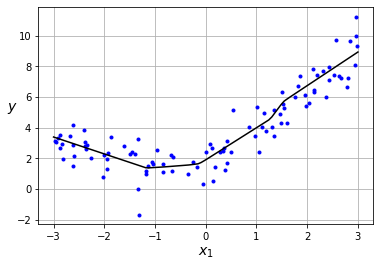

In [ ]:
x_new = np.linspace(-3, 3, 100)
x_new = x_new.reshape(len(x_new),1)
y_pred = mlp(x_new)
    
plt.plot(X, Y, "b.")
plt.plot(x_new, y_pred, "-k")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

Nuestro framework es capaz de llevar a cabo la tarea de regresión, y si ahora queremos llevar a cabo tareas de clasificación es tan sencillo como cambiar la función de pérdida y de activación en la clase `MLP`.

## Resumen

En este post hemos visto como podemos implementar nuestro propio framework de perceptrón multicapa. Las ideas expuestas son muy similares a las utilizadas internamente por frameworks de `redes neuronales` como `Pytorch` o `Tensorflow`, lo cual nos permitirá conocer en detalle como funcionan estos frameworks a la hora de trabajar con arquitecturas más complicadas. Nuestro framework es flexible, ya que con la misma interfaz es capaz de llevar a cabo las diferentes tareas y de manera muy sencilla podemos probar diferentes arquitecturas de `MLP` con más o menos capas, diferentes funciones de pérdida y de activación, etc. En este [post](https://sensioai.com/blog/017_clasificacion_multiclase) utilizamos el dataset MNIST para clasificación de imágenes, ¿te ves capaz de utilizar nuestro framework para esta tarea?